In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'give me',
    'not give me',
]

data = np.concatenate([
    np.load('dataset/seq_give_me_1683794228.npy'),
    np.load('dataset/seq_not_give_me_1683794228.npy'),
], axis=0)

data.shape

(1979, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1979, 30, 99)
(1979,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1979, 2)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1781, 30, 99) (1781, 2)
(198, 30, 99) (198, 2)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(256, activation='relu', input_shape=x_train.shape[1:3], dropout=0.2),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(len(actions), activation='softmax')
    
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               364544    
                                                                 
 dense_5 (Dense)             (None, 1024)              263168    
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 629,762
Trainable params: 629,762
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 1292.4856 - acc: 0.5811
Epoch 1: val_acc improved from -inf to 0.52525, saving model to models/model.h5
56/56 [==============================] - 8s 104ms/step - loss: 1292.4856 - acc: 0.5811 - val_loss: 1700.0177 - val_acc: 0.5253 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 5153.6592 - acc: 0.5334
Epoch 2: val_acc did not improve from 0.52525
56/56 [==============================] - 6s 115ms/step - loss: 5153.6592 - acc: 0.5334 - val_loss: 3553.2356 - val_acc: 0.4798 - lr: 0.0010
Epoch 3/200
56/56 [==============================] - ETA: 0s - loss: 5390.8491 - acc: 0.5373
Epoch 3: val_acc did not improve from 0.52525
56/56 [==============================] - 6s 100ms/step - loss: 5390.8491 - acc: 0.5373 - val_loss: 1181.5587 - val_acc: 0.5202 - lr: 0.0010
Epoch 4/200
56/56 [==============================] - ETA: 0s - loss: 1215.3790 - acc: 0.5497
Epoch 4: val_acc improved from 0.525

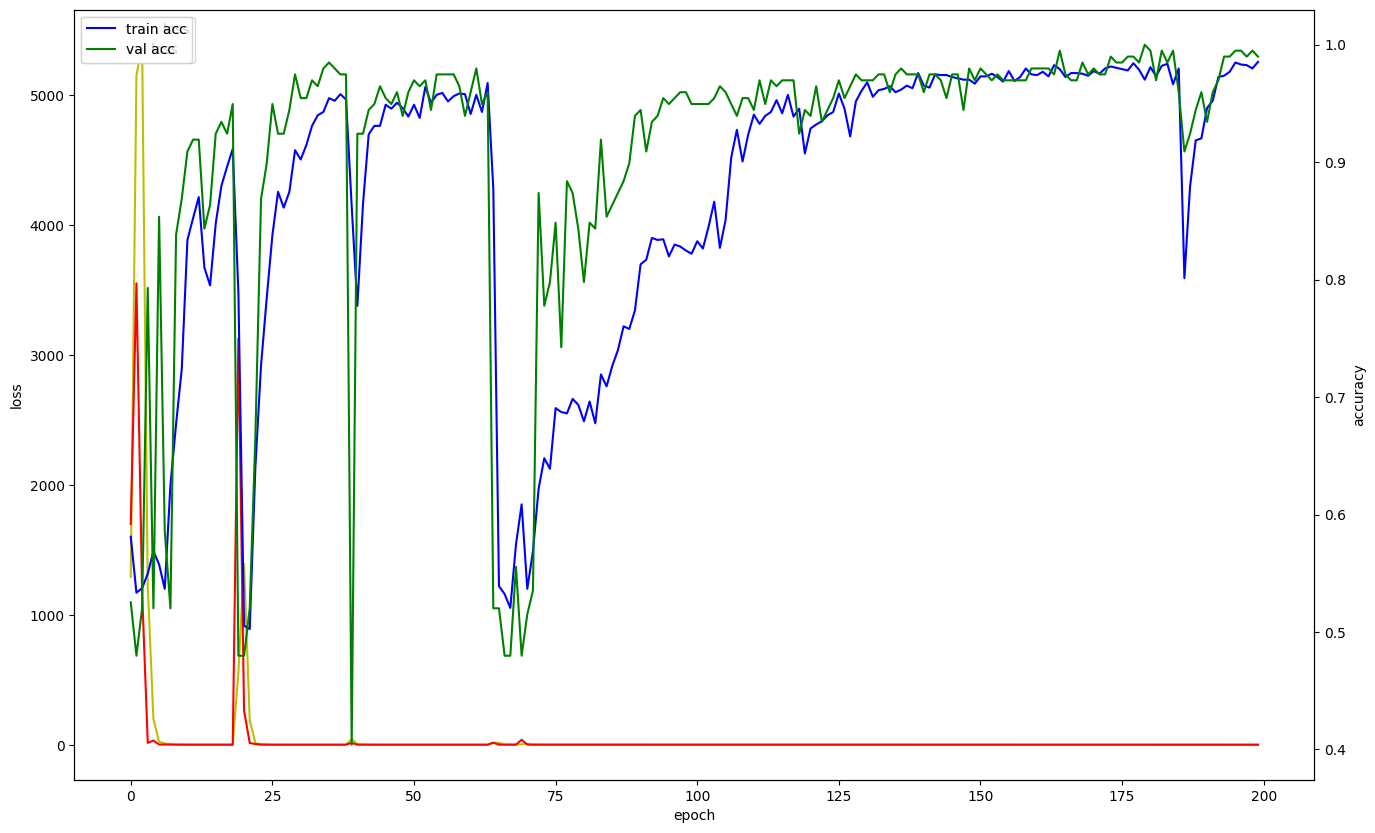

In [16]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [17]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

7/7 [==============================] - 1s 40ms/step


array([[[103,   0],
        [  0,  95]],

       [[ 95,   0],
        [  0, 103]]])

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical

# 데이터셋 디렉토리 경로 설정
dataset_dir = 'dataset'
actions = os.listdir(dataset_dir)
num_actions = len(actions)

# 데이터셋 불러오기
X = []
y = []
for i, action in enumerate(actions):
    action_dir = os.path.join(dataset_dir, action)
    for filename in os.listdir(action_dir):
        image_path = os.path.join(action_dir, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        X.append(image)
        y.append(i)

# 데이터 전처리 및 분할
X = np.array(X)
y = np.array(y)
y = to_categorical(y, num_classes=num_actions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 구성
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(num_actions, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# 학습된 모델 저장
model.save('hand_gesture_model.h5')


